In [53]:
import numpy as np
import torch
import torch.nn
import torch.optim
from abc import abstractmethod
from collections import defaultdict
from functools import lru_cache
from itertools import count
from typing import List, Dict
from typing import Tuple, Any
from sklearn import ensemble
from sklearn.metrics import mean_squared_error
from torch.nn import MSELoss, ReLU
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [54]:
from importlib import reload
from config import Config
import config
from data import MDataset, Graph, load_graphs, save_dataset_pkl, load_dataset_pkl, save_scalers_pkl, load_scalers_pkl
import data
from base_module import MModule
import base_module
from executor import single_train_loop, nested_detach
import executor
from objects import ModelType
import objects
from metric import MetricUtil
import metric
from logger import init_logging
import logger
reload(config)
reload(data)
reload(base_module)
reload(executor)
reload(objects)
reload(metric)
reload(logger)
from config import Config
from data import MDataset, Graph, load_graphs
from base_module import MModule
from objects import ModelType
from metric import MetricUtil
from logger import init_logging
init_logging()

datasets_path: /root/guohao/repos/DLT-perf-model/datasets
configs_path: /root/guohao/repos/DLT-perf-model/notebooks/configs


In [55]:
dataset_environment_str = "T4_CPU100"
normalizer_cls = StandardScaler # MinMaxScaler
dummy = False
model_type = ModelType.PerfNet


In [56]:

eval_graphs = load_graphs(dataset_environment_str,
                            train_or_eval="train",
                            use_dummy=dummy,
                            max_row=10_000)
train_graphs = load_graphs(dataset_environment_str,
                            train_or_eval="train",
                            use_dummy=dummy,
                            max_row=100_000)

[2023-12-07 16:25:04,373] {data.py:441} INFO - Loading graphs train
[2023-12-07 16:25:04,373] {data.py:412} INFO - Loading merged.csv
[2023-12-07 16:25:04,413] {data.py:415} INFO - Loaded merged.csv, 10000 rows
[2023-12-07 16:25:07,101] {data.py:421} INFO - Loaded efficientnet_v2_s.3_7.csv, 2412 rows
[2023-12-07 16:25:10,115] {data.py:421} INFO - Loaded efficientnet_b5.156_7.csv, 2707 rows
[2023-12-07 16:25:11,378] {data.py:421} INFO - Loaded regnet_x_8gf.103_7.csv, 1138 rows
[2023-12-07 16:25:13,120] {data.py:421} INFO - Loaded resnet101.160_7.csv, 1598 rows
[2023-12-07 16:25:14,334] {data.py:421} INFO - Loaded regnet_x_16gf.127_7.csv, 1092 rows
[2023-12-07 16:25:14,953] {data.py:421} INFO - Loaded resnet34.205_7.csv, 563 rows
[2023-12-07 16:25:15,502] {data.py:421} INFO - Loaded resnet101.79_7.csv, 490 rows
[2023-12-07 16:25:15,505] {data.py:441} INFO - Loading graphs train
[2023-12-07 16:25:15,506] {data.py:412} INFO - Loading merged.csv
[2023-12-07 16:25:15,763] {data.py:415} INFO 

In [57]:
train_configs = {
    ModelType.MLP.name: Config.from_dict({
        "model": "MLP",
        "all_seed": 42,
        "dataset_environment_str": dataset_environment_str,
        "dataset_normalization": "Standard",
        "dataset_params": {
            "duration_summed": False,
        },
        "dataset_dummy": False,
        "batch_size": 64,
        "eval_steps": 500,
        "learning_rate": 1e-3,
        "epochs": 5,
        "optimizer": "Adam",
        "meta_configs": {
            "learning_rate": 0.005,
            "meta_learning_rate": 0.001,
            "meta_train_steps": 1000,
            "meta_task_per_step": 8,
            "meta_fast_adaption_step": 5,
            "meta_dataset_train_environment_strs": [dataset_environment_str],
            "meta_dataset_eval_environment_strs": [dataset_environment_str],
        },
    }),
    ModelType.PerfNet.name: Config.from_dict({
        "model": "PerfNet",
        "dataset_environment_str": dataset_environment_str,
        "dataset_normalization": "Standard",
        "all_seed": 42,
        "dataset_params": {
            "duration_summed": False,
        },
        "dataset_dummy": True,
        "batch_size": 16,
        "eval_steps": 100,
        "learning_rate": 1e-3,
        "epochs": 100,
        "optimizer": "Adam",
        "meta_configs": {
            "learning_rate": 0.005,
            "meta_learning_rate": 0.001,
            "meta_train_steps": 1000,
            "meta_task_per_step": 8,
            "meta_fast_adaption_step": 5,
            "meta_dataset_train_environment_strs": [dataset_environment_str],
            "meta_dataset_eval_environment_strs": [dataset_environment_str],
        },
    })
}

conf = train_configs[model_type.name]

In [58]:

def init_dataset(graphs: List[Graph]) -> MDataset:
    op_X, op_Y = list(), list()
    data_idx_to_graph = dict()
    counter = iter(count())
    op_feature_len = 0

    def node_features(g: Graph) -> Tuple[
        List[Dict], List[Dict]]:
        X, Y = list(), list()
        for i, node in enumerate(g.nodes):
            x_op_feature = node.op.to_feature_array("complex")
            x = {
                "x_op_feature": x_op_feature
            }
            node_durations = (node.duration,node.gap)
            x["x_id"] = i
            x["x_graph_id"] = g.ID
            y = {"y_node_durations": node_durations, "y_id": i, "y_graph_id": g.ID}
            X.append(x)
            Y.append(y)
        return X, Y

    for graph in graphs:
        X, Y = node_features(graph)
        for x in X:
            # if len(x['x_op_feature'])!=37:
            #     print(x['x_graph_id'], len(x['x_op_feature']))
            op_feature_len = max(op_feature_len, len(x["x_op_feature"]))
        op_X.extend(X)
        op_Y.extend(Y)
        for i in range(len(X)):
            data_idx_to_graph[next(counter)] = graph
    for x in op_X:
        v = x["x_op_feature"]
        x["x_op_feature"] = np.pad(v, (0, op_feature_len - v.size))

    dataset = MDataset(op_X, op_Y)
    return dataset

train_ds = init_dataset(train_graphs)
eval_ds = init_dataset(eval_graphs)

In [59]:
def get_scalers(ds):
    scaler_cls = normalizer_cls
    op_feature_array = list()
    y_array = list()

    for data in ds:
        feature, label = data
        op_feature_array.append(feature["x_op_feature"])
        y_array.append(label["y_node_durations"])

    op_feature_array = np.array(op_feature_array)
    y_array = np.array(y_array)

    op_feature_scaler = scaler_cls()
    op_feature_scaler.fit(op_feature_array)

    y_scaler = scaler_cls()
    y_scaler.fit(y_array)
    return op_feature_scaler, y_scaler

scalers = get_scalers(train_ds)
op_feature_scaler, y_scaler = scalers


In [60]:

def preprocess_dataset(ds: MDataset) -> MDataset:
    op_feature_array = list()
    y_array = list()

    for data in ds:
        feature, label = data
        op_feature_array.append(feature["x_op_feature"])
        y_array.append(label["y_node_durations"])

    op_feature_array = np.array(op_feature_array, dtype=np.float32)
    y_array = np.array(y_array, dtype=np.float32)


    op_feature_array = op_feature_scaler.transform(op_feature_array)
    y_array = y_scaler.transform(y_array)

    processed_features = list()
    processed_labels = list()
    for i, data in enumerate(ds):
        feature, label = data
        processed_features.append({
            "x_id": feature["x_id"],
            "x_graph_id": feature["x_graph_id"],
            # 运行时再传到cuda那边
            # "x_op_feature": torch.Tensor(op_feature_array[i]).to(device=self.conf.device)
            "x_op_feature": torch.Tensor(op_feature_array[i])
        })
        processed_labels.append({
            "y_id": label["y_id"],
            "y_graph_id": label["y_graph_id"],
            # "y_node_durations": torch.Tensor(y_array[i]).to(device=self.conf.device)
            "y_node_durations": torch.Tensor(y_array[i])
        })

    ds = MDataset(processed_features, processed_labels)
    return ds

preprocessed_train_ds = preprocess_dataset(train_ds)
preprocessed_eval_ds = preprocess_dataset(eval_ds)


In [61]:
save_dataset_pkl(preprocessed_train_ds, conf.dataset_environment, "OpBased", 'train',
                         conf.dataset_normalization)
save_dataset_pkl(preprocessed_eval_ds, conf.dataset_environment, "OpBased", 'eval',
                         conf.dataset_normalization)
save_scalers_pkl(scalers, conf.dataset_environment, "OpBased", 'train',
                         conf.dataset_normalization)

In [62]:
preprocessed_train_ds = load_dataset_pkl(conf.dataset_environment, "OpBased", 'train', 
                                         conf.dataset_normalization)
preprocessed_eval_ds = load_dataset_pkl(conf.dataset_environment, "OpBased", 'eval',
                                        conf.dataset_normalization)
scalers = load_scalers_pkl(conf.dataset_environment, "OpBased", 'train',
                           conf.dataset_normalization)
op_feature_scaler, y_scaler = scalers

Loading dataset T4_CPU100 OpBased train Standard
Loading dataset T4_CPU100 OpBased eval Standard
Loading scalers T4_CPU100 OpBased train, Standard


In [63]:
def compute_evaluate_metrics(input_batches, output_batches, eval_loss) -> Dict[str, float]:
    batches_len = len(input_batches)

    def compute_op_durations(_logits):
        transformed: np.ndarray = y_scaler.inverse_transform(_logits)
        durations = transformed.sum(axis=1)
        return durations

    graph_id_to_duration_pred = defaultdict(int)
    for idx in range(batches_len):
        inputs = input_batches[idx]
        logits = output_batches[idx]
        logits = nested_detach(logits)
        logits = logits.cpu().numpy()
        graph_ids = inputs["x_graph_id"]
        op_durations = compute_op_durations(logits)
        for i, graph_id in enumerate(graph_ids):
            op_duration = op_durations[i].item()
            graph_id_to_duration_pred[graph_id] += op_duration
    duration_metrics = MetricUtil.compute_duration_metrics(eval_graphs, graph_id_to_duration_pred)
    return {"eval_loss": eval_loss, **duration_metrics}


In [64]:

def to_device(conf, features, labels):
    features['x_op_feature'] = features["x_op_feature"].to(device=conf.device)
    labels['y_node_durations'] = labels['y_node_durations'].to(device=conf.device)
    return features, labels

In [65]:
class MLPModel(MModule):

    @staticmethod
    def dimension_len(t):
        return t[-1] - t[0]

    def __init__(self, input_dimension, output_dimension, **kwargs):
        super().__init__(**kwargs)
        self.input = torch.nn.Linear(input_dimension, 128)
        self.relu1 = ReLU()
        self.dense1 = torch.nn.Linear(128, 64)
        self.relu2 = ReLU()
        self.dense2 = torch.nn.Linear(64, 32)
        self.relu3 = ReLU()
        self.output = torch.nn.Linear(32, output_dimension)
        self.loss_fn = MSELoss()

    def forward(self, X):
        X = X["x_op_feature"]
        X = self.input(X)
        X = self.relu1(X)
        X = self.dense1(X)
        X = self.relu2(X)
        X = self.dense2(X)
        X = self.relu3(X)
        Y = self.output(X)
        return Y

    def compute_loss(self, outputs, Y):
        node_durations = Y["y_node_durations"]
        loss = self.loss_fn(outputs, node_durations)
        return loss


def init_MLP_model(self) -> MModule | Any:
    sample_preprocessed_ds = preprocessed_train_ds
    sample_x_dict = sample_preprocessed_ds.features[0]
    sample_y_dict = sample_preprocessed_ds.labels[0]
    return MLPModel(input_dimension=len(sample_x_dict["x_op_feature"]),
                    output_dimension=len(sample_y_dict["y_node_durations"]))

In [66]:

class PerfNetModel(MModule):
    @staticmethod
    def dimension_len(t):
        return t[-1] - t[0]

    def __init__(self, output_dimension, **kwargs):
        super().__init__(**kwargs)
        self.conv1 = torch.nn.LazyConv1d(out_channels=32, kernel_size=3, bias=True, padding_mode='zeros')
        self.conv2 = torch.nn.LazyConv1d(out_channels=128, kernel_size=2, bias=True, padding_mode='zeros')
        self.flatten = torch.nn.Flatten()
        self.dense1 = torch.nn.LazyLinear(32)
        self.relu1 = ReLU()
        self.dense2 = torch.nn.LazyLinear(64)
        self.relu2 = ReLU()
        self.dense3 = torch.nn.LazyLinear(128)
        self.relu3 = ReLU()
        self.dense4 = torch.nn.LazyLinear(256)
        self.relu4 = ReLU()
        self.dropout = torch.nn.Dropout(p=0.3)
        self.output = torch.nn.LazyLinear(output_dimension)
        self.loss_fn = MSELoss()

    def forward(self, X):
        X = X["x_op_feature"]
        X = torch.unsqueeze(X, dim=1)
        X = self.conv1(X)
        X = self.conv2(X)
        X = self.flatten(X)
        X = self.dense1(X)
        X = self.relu1(X)
        X = self.dense2(X)
        X = self.relu2(X)
        X = self.dense3(X)
        X = self.relu3(X)
        X = self.dense4(X)
        X = self.relu4(X)
        X = self.dropout(X)
        Y = self.output(X)
        return Y

    def compute_loss(self, outputs, Y):
        node_durations = Y["y_node_durations"]
        loss = self.loss_fn(outputs, node_durations)
        return loss


def init_PerfNet_model(self) -> MModule | Any:
    sample_y_dict = preprocessed_train_ds.labels[0]
    return PerfNetModel(output_dimension=len(sample_y_dict["y_node_durations"]))



In [67]:


init_model_funcs = {
    ModelType.MLP.name: init_MLP_model,
    ModelType.PerfNet.name: init_PerfNet_model,
}


[2023-12-07 16:27:59,580] {executor.py:43} INFO - ModelType.MLP start single training.
[2023-12-07 16:27:59,580] {executor.py:45} INFO - ModelType.MLP training epoch 0


  0%|          | 0/1563 [00:00<?, ?it/s]

[2023-12-07 16:27:59,592] {executor.py:62} INFO - ModelType.MLP trained for 0.011919462 seconds.
[2023-12-07 16:27:59,592] {executor.py:63} INFO - ModelType.MLP eval at step 0.
[2023-12-07 16:27:59,785] {executor.py:67} INFO - ModelType.MLP train loss: 0.2926711440086365, eval metrics: {'eval_loss': 0.41445513182930693, 'MRE': 2.0667413230420926, 'MAE': 1.80564512679328, 'RMSE': 858.5537140990962}


  0%|          | 1/1563 [00:00<05:24,  4.82it/s]

 31%|███       | 485/1563 [00:01<00:03, 331.23it/s]

[2023-12-07 16:28:01,265] {executor.py:62} INFO - ModelType.MLP trained for 1.684716855 seconds.
[2023-12-07 16:28:01,265] {executor.py:63} INFO - ModelType.MLP eval at step 500.
[2023-12-07 16:28:01,450] {executor.py:67} INFO - ModelType.MLP train loss: 0.27188020944595337, eval metrics: {'eval_loss': 0.1751688636044503, 'MRE': 1.4813342496773656, 'MAE': 1.0942714003506728, 'RMSE': 597.3618538908265}


 62%|██████▏   | 976/1563 [00:03<00:01, 344.95it/s]

[2023-12-07 16:28:02,907] {executor.py:62} INFO - ModelType.MLP trained for 3.327249669 seconds.
[2023-12-07 16:28:02,908] {executor.py:63} INFO - ModelType.MLP eval at step 1000.
[2023-12-07 16:28:03,081] {executor.py:67} INFO - ModelType.MLP train loss: 0.17368385195732117, eval metrics: {'eval_loss': 0.6020170151505169, 'MRE': 11.509098801560565, 'MAE': 8.302196571775612, 'RMSE': 4089.8363718165833}


 94%|█████████▍| 1477/1563 [00:04<00:00, 404.47it/s]

[2023-12-07 16:28:04,397] {executor.py:62} INFO - ModelType.MLP trained for 4.816766982 seconds.
[2023-12-07 16:28:04,397] {executor.py:63} INFO - ModelType.MLP eval at step 1500.
[2023-12-07 16:28:04,569] {executor.py:67} INFO - ModelType.MLP train loss: 0.03941972926259041, eval metrics: {'eval_loss': 0.13073494246490536, 'MRE': 1.3673864410972474, 'MAE': 0.9614422553526215, 'RMSE': 452.8785447292928}


100%|██████████| 1563/1563 [00:05<00:00, 303.04it/s]

[2023-12-07 16:28:04,741] {executor.py:45} INFO - ModelType.MLP training epoch 1



 27%|██▋       | 416/1563 [00:01<00:02, 413.74it/s]

[2023-12-07 16:28:05,813] {executor.py:62} INFO - ModelType.MLP trained for 6.232795287 seconds.
[2023-12-07 16:28:05,813] {executor.py:63} INFO - ModelType.MLP eval at step 2000.
[2023-12-07 16:28:05,985] {executor.py:67} INFO - ModelType.MLP train loss: 0.04426213353872299, eval metrics: {'eval_loss': 0.13212103535166117, 'MRE': 2.2142521087903506, 'MAE': 1.4655216846491426, 'RMSE': 721.428463195888}


 59%|█████▉    | 923/1563 [00:02<00:01, 414.35it/s]

[2023-12-07 16:28:07,196] {executor.py:62} INFO - ModelType.MLP trained for 7.616388912 seconds.
[2023-12-07 16:28:07,197] {executor.py:63} INFO - ModelType.MLP eval at step 2500.
[2023-12-07 16:28:07,366] {executor.py:67} INFO - ModelType.MLP train loss: 0.08204492181539536, eval metrics: {'eval_loss': 0.1230799805663621, 'MRE': 0.7199430145747513, 'MAE': 0.44386906327548625, 'RMSE': 207.22263078679103}


 91%|█████████ | 1424/1563 [00:03<00:00, 407.84it/s]

[2023-12-07 16:28:08,599] {executor.py:62} INFO - ModelType.MLP trained for 9.018689313 seconds.
[2023-12-07 16:28:08,599] {executor.py:63} INFO - ModelType.MLP eval at step 3000.
[2023-12-07 16:28:08,772] {executor.py:67} INFO - ModelType.MLP train loss: 0.09698854386806488, eval metrics: {'eval_loss': 0.1164178784564434, 'MRE': 1.4996897298567098, 'MAE': 1.0028419271334266, 'RMSE': 452.4983315067323}


100%|██████████| 1563/1563 [00:04<00:00, 358.65it/s]

[2023-12-07 16:28:09,102] {executor.py:45} INFO - ModelType.MLP training epoch 2



 24%|██▎       | 370/1563 [00:00<00:02, 410.32it/s]

[2023-12-07 16:28:10,029] {executor.py:62} INFO - ModelType.MLP trained for 10.44927615 seconds.
[2023-12-07 16:28:10,030] {executor.py:63} INFO - ModelType.MLP eval at step 3500.
[2023-12-07 16:28:10,203] {executor.py:67} INFO - ModelType.MLP train loss: 0.06979097425937653, eval metrics: {'eval_loss': 0.14574040148027573, 'MRE': 0.8543636061203418, 'MAE': 0.6958308826470425, 'RMSE': 427.6274714782178}


 56%|█████▌    | 870/1563 [00:02<00:01, 410.14it/s]

[2023-12-07 16:28:11,445] {executor.py:62} INFO - ModelType.MLP trained for 11.865090672 seconds.
[2023-12-07 16:28:11,446] {executor.py:63} INFO - ModelType.MLP eval at step 4000.
[2023-12-07 16:28:11,618] {executor.py:67} INFO - ModelType.MLP train loss: 0.5101016163825989, eval metrics: {'eval_loss': 0.10648521610793722, 'MRE': 0.4990603428159029, 'MAE': 0.42049797897492164, 'RMSE': 235.583059956394}


 85%|████████▌ | 1333/1563 [00:03<00:00, 410.27it/s]

[2023-12-07 16:28:12,844] {executor.py:62} INFO - ModelType.MLP trained for 13.263782777 seconds.
[2023-12-07 16:28:12,844] {executor.py:63} INFO - ModelType.MLP eval at step 4500.
[2023-12-07 16:28:13,011] {executor.py:67} INFO - ModelType.MLP train loss: 0.07963445037603378, eval metrics: {'eval_loss': 0.11993358893450468, 'MRE': 1.5509054924587435, 'MAE': 1.0164609523071277, 'RMSE': 577.3125327044181}


100%|██████████| 1563/1563 [00:04<00:00, 355.18it/s]

[2023-12-07 16:28:13,505] {executor.py:45} INFO - ModelType.MLP training epoch 3



 19%|█▊        | 291/1563 [00:00<00:03, 414.62it/s]

[2023-12-07 16:28:14,267] {executor.py:62} INFO - ModelType.MLP trained for 14.687555571 seconds.
[2023-12-07 16:28:14,268] {executor.py:63} INFO - ModelType.MLP eval at step 5000.
[2023-12-07 16:28:14,436] {executor.py:67} INFO - ModelType.MLP train loss: 6.725756645202637, eval metrics: {'eval_loss': 0.10944840877545274, 'MRE': 0.9139609008612256, 'MAE': 0.7243393767072647, 'RMSE': 363.5317392993932}


 52%|█████▏    | 807/1563 [00:02<00:01, 416.57it/s]

[2023-12-07 16:28:15,650] {executor.py:62} INFO - ModelType.MLP trained for 16.069821556 seconds.
[2023-12-07 16:28:15,650] {executor.py:63} INFO - ModelType.MLP eval at step 5500.
[2023-12-07 16:28:15,822] {executor.py:67} INFO - ModelType.MLP train loss: 0.7470039129257202, eval metrics: {'eval_loss': 0.10428372713526604, 'MRE': 0.23962933403852568, 'MAE': 0.23063853725424796, 'RMSE': 129.8649520414638}


 81%|████████▏ | 1272/1563 [00:03<00:00, 410.02it/s]

[2023-12-07 16:28:17,054] {executor.py:62} INFO - ModelType.MLP trained for 17.473830494 seconds.
[2023-12-07 16:28:17,054] {executor.py:63} INFO - ModelType.MLP eval at step 6000.
[2023-12-07 16:28:17,221] {executor.py:67} INFO - ModelType.MLP train loss: 0.04923241585493088, eval metrics: {'eval_loss': 0.10922970097055243, 'MRE': 1.1138496974571663, 'MAE': 0.7928926646336355, 'RMSE': 373.6880281958285}


100%|██████████| 1563/1563 [00:04<00:00, 357.41it/s]

[2023-12-07 16:28:17,881] {executor.py:45} INFO - ModelType.MLP training epoch 4



 16%|█▌        | 245/1563 [00:00<00:03, 409.07it/s]

[2023-12-07 16:28:18,501] {executor.py:62} INFO - ModelType.MLP trained for 18.921195633 seconds.
[2023-12-07 16:28:18,502] {executor.py:63} INFO - ModelType.MLP eval at step 6500.
[2023-12-07 16:28:18,677] {executor.py:67} INFO - ModelType.MLP train loss: 0.16199521720409393, eval metrics: {'eval_loss': 0.15158129197687717, 'MRE': 0.5346792765171406, 'MAE': 0.6673980756995438, 'RMSE': 430.3162701298953}


 48%|████▊     | 745/1563 [00:02<00:02, 406.65it/s]

[2023-12-07 16:28:19,931] {executor.py:62} INFO - ModelType.MLP trained for 20.351179055 seconds.
[2023-12-07 16:28:19,932] {executor.py:63} INFO - ModelType.MLP eval at step 7000.
[2023-12-07 16:28:20,105] {executor.py:67} INFO - ModelType.MLP train loss: 0.06898534297943115, eval metrics: {'eval_loss': 0.1168469415471895, 'MRE': 0.39177172715204694, 'MAE': 0.28562674039986014, 'RMSE': 151.1466370684984}


 77%|███████▋  | 1207/1563 [00:03<00:00, 406.87it/s]

[2023-12-07 16:28:21,357] {executor.py:62} INFO - ModelType.MLP trained for 21.776737568 seconds.
[2023-12-07 16:28:21,357] {executor.py:63} INFO - ModelType.MLP eval at step 7500.
[2023-12-07 16:28:21,532] {executor.py:67} INFO - ModelType.MLP train loss: 0.2057148516178131, eval metrics: {'eval_loss': 0.1057427419500817, 'MRE': 0.9130410026514479, 'MAE': 0.7668482596221243, 'RMSE': 406.04115689779854}


100%|██████████| 1563/1563 [00:04<00:00, 347.31it/s]


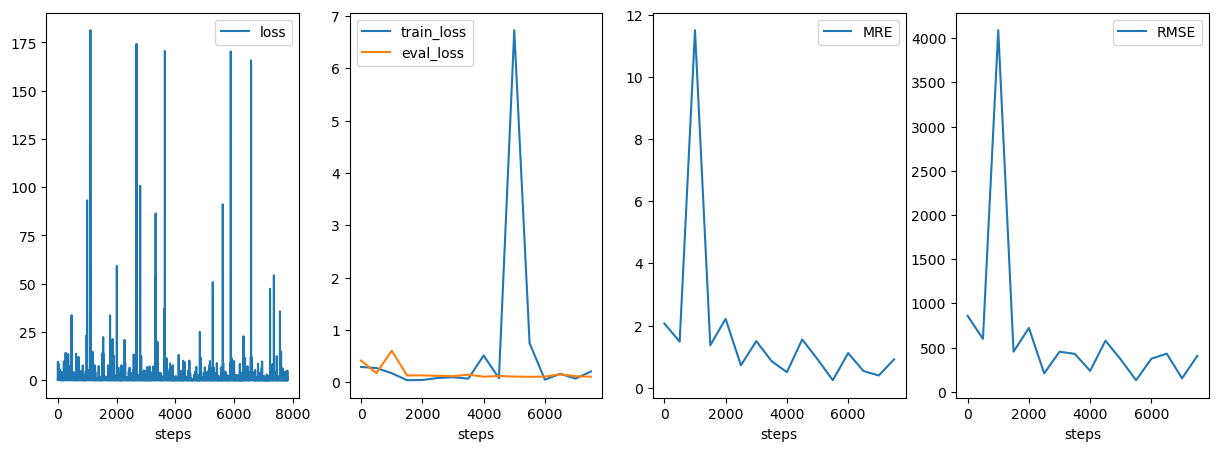

In [68]:
init_model = init_model_funcs[model_type.name]

model = init_model(conf)
model = model.to(conf.device)

single_train_loop(model_type, conf, preprocessed_train_ds, preprocessed_eval_ds, model, compute_evaluate_metrics, to_device)
